In [1]:
import json
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import imutils

In [2]:
# uploading the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lakshh21","key":"a2ae428b98ebadf82ed5c18961c17cd0"}'}

In [3]:
kaggle_credentials = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:07<00:00, 22.9MB/s]
100% 149M/149M [00:07<00:00, 20.4MB/s]


In [5]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data


In [6]:
from zipfile import ZipFile
# Unzip the downloaded dataset
with ZipFile('/content/brain-tumor-mri-dataset.zip', 'r') as zipObj:
  zipObj.extractall()

In [7]:
def get_df(train_path):
    data = []

    for label in os.listdir(train_path):
        label_path = os.path.join(train_path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                data.append({'Image_path': os.path.join(label_path, image), 'Class': label})

    return pd.DataFrame(data)

In [8]:
df_train = get_df('/content/Training')
df_test = get_df('/content/Testing')

In [9]:
df_train.head()

,Image_path,Class
0,/content/Training/notumor/Tr-no_0547.jpg,notumor
1,/content/Training/notumor/Tr-no_0328.jpg,notumor
2,/content/Training/notumor/Tr-no_0550.jpg,notumor
3,/content/Training/notumor/Tr-no_1076.jpg,notumor
4,/content/Training/notumor/Tr-no_0776.jpg,notumor


In [10]:
df_test.head()

,Image_path,Class
0,/content/Testing/notumor/Te-no_0343.jpg,notumor
1,/content/Testing/notumor/Te-no_0308.jpg,notumor
2,/content/Testing/notumor/Te-no_0159.jpg,notumor
3,/content/Testing/notumor/Te-no_0338.jpg,notumor
4,/content/Testing/notumor/Te-no_0231.jpg,notumor


In [11]:
df_train['Class'].value_counts()

,count
Class,
notumor,1595
pituitary,1457
meningioma,1339
glioma,1321


In [12]:
df_test['Class'].value_counts()

,count
Class,
notumor,405
meningioma,306
pituitary,300
glioma,300


([<matplotlib.patches.Wedge at 0x7c7e866b4190>,
 [Text(0.7031968008021029, 0.8458807595291951, 'notumor'),
  Text(-0.9166283476245626, 0.6081056424101525, 'pituitary'),
  Text(-0.6380177336501233, -0.8960654951218469, 'meningioma'),
  Text(0.822219028426833, -0.7307228402703962, 'glioma')],
 [Text(0.3835618913466015, 0.4613895051977427, '28%'),
  Text(-0.4999790987043068, 0.3316939867691741, '26%'),
  Text(-0.34800967290006724, -0.48876299733918915, '23%'),
  Text(0.4484831064146361, -0.39857609469294336, '23%')])

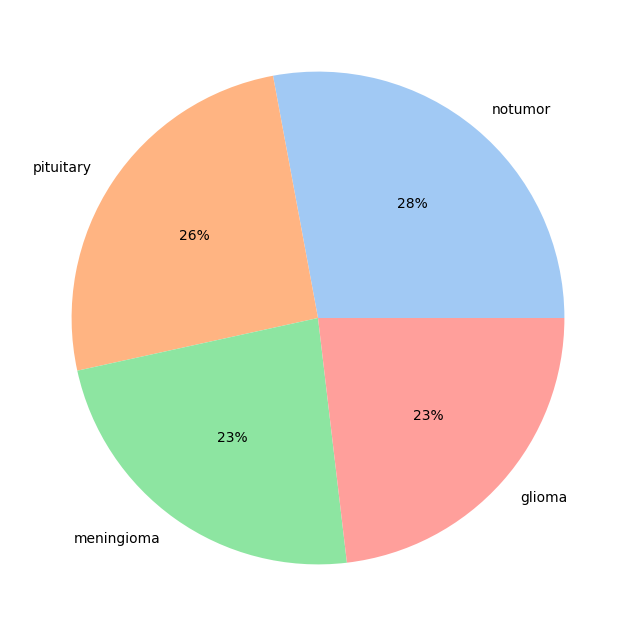

In [13]:
plt.figure(figsize=(8,8))
colors = sns.color_palette('pastel')
plt.pie(df_train['Class'].value_counts(), labels=df_train['Class'].value_counts().index, colors=colors, autopct='%.0f%%')

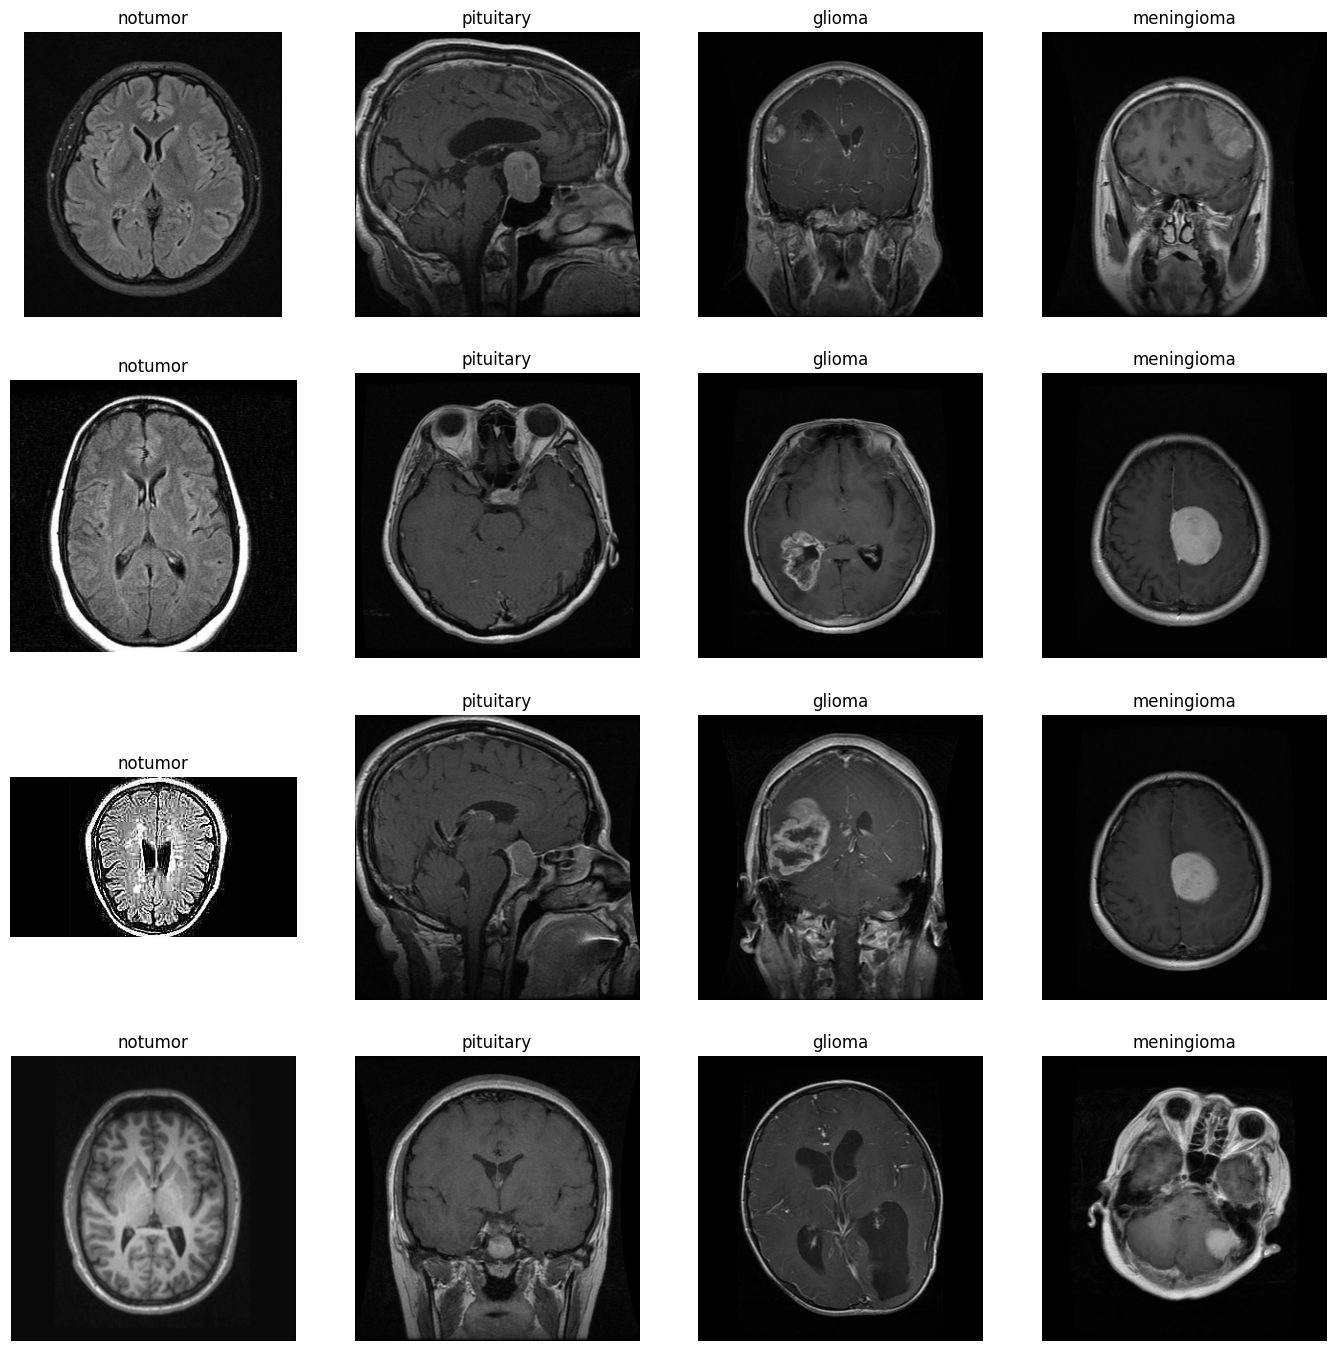

In [14]:
plt.figure(figsize=(17,17))

index = 0
for i  in range(1,5):
  for c in df_train['Class'].unique():
      plt.subplot(4,4,index+1)
      index += 1
      img_path = np.random.choice(df_train[df_train['Class'] == c]['Image_path'].values)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.title(c)
      plt.axis('off')


In [15]:
def crop_image(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # covnerting it into a black and white image
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0) # blurring to remove noise and smoothen image for detecting contours
    img_thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY)[1] # pixels below 45 become black and above 255 become white, used for segmentation so they stand out from background
    # converts it into a bianry format black or white
    img_thresh = cv2.erode(img_thresh, None, iterations=2) # removes small noise and shrinks white regions
    img_thresh = cv2.dilate(img_thresh, None, iterations=2) # expands white regions

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # contours are outlines of binary image
    contours = imutils.grab_contours(contours)
    # cv2.RETR_EXTERNAL: Retrieves only the outermost contours
    # cv2.CHAIN_APPROX_NONE: Stores all contour points without compression.
    # imutils.grab_contours(contours): Ensures compatibility with different OpenCV versions.

    if not contours:
        return image  # Return original image if no contour is found

    c = max(contours, key=cv2.contourArea) # finding extreme points of the contours
    extLeft = tuple(c[c[:, :, 0].argmin()])[0]
    extRight = tuple(c[c[:, :, 0].argmax()])[0]
    extTop = tuple(c[c[:, :, 1].argmin()])[0]
    extBottom = tuple(c[c[:, :, 1].argmax()])[0]

    new_img = image[extTop[1]: extBottom[1], extLeft[0]:extRight[0]] # cropping with extreme points
    return new_img

In [16]:
image_path = '/content/Testing/glioma/Te-glTr_0000.jpg'
image = cv2.imread(image_path)
os.path.basename(image_path)

'Te-glTr_0000.jpg'

In [17]:
def process_and_save_images(df, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    cropped_paths = []
    for index, row in df.iterrows():
        image_path = row['Image_path']
        class_label = row['Class']  # Get the class label from DataFrame
        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Could not read {image_path}")
            cropped_paths.append(None)
            continue

        cropped_img = crop_image(image)
        cropped_img = cv2.resize(cropped_img, (240, 240))

        # Create a subdirectory for the class if it doesn't exist
        class_dir = os.path.join(save_dir, class_label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the cropped image inside the corresponding class folder
        cropped_filename = f"cropped_{os.path.basename(image_path)}"
        cropped_path = os.path.join(class_dir, cropped_filename)
        cv2.imwrite(cropped_path, cropped_img)
        cropped_paths.append(cropped_path)

    df['Cropped_Image_Path'] = cropped_paths
    return df

In [18]:
df_train = process_and_save_images(df_train, '/content/Cropped_Training')
df_test = process_and_save_images(df_test, '/content/Cropped_Testing')

In [19]:
df_train.head()

,Image_path,Class,Cropped_Image_Path
0,/content/Training/notumor/Tr-no_0547.jpg,notumor,/content/Cropped_Training/notumor/cropped_Tr-n...
1,/content/Training/notumor/Tr-no_0328.jpg,notumor,/content/Cropped_Training/notumor/cropped_Tr-n...
2,/content/Training/notumor/Tr-no_0550.jpg,notumor,/content/Cropped_Training/notumor/cropped_Tr-n...
3,/content/Training/notumor/Tr-no_1076.jpg,notumor,/content/Cropped_Training/notumor/cropped_Tr-n...
4,/content/Training/notumor/Tr-no_0776.jpg,notumor,/content/Cropped_Training/notumor/cropped_Tr-n...


Text(0.5, 1.0, 'Cropped Image')

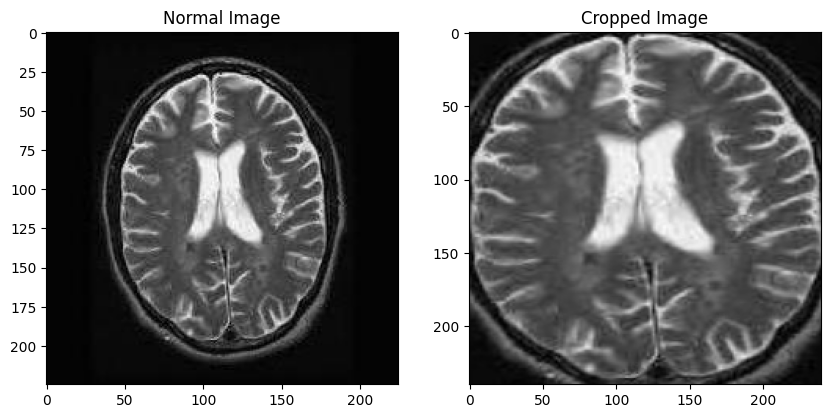

In [20]:
# Visualizing cropped vs normal image

normal_img = cv2.imread(df_train['Image_path'][0])
cropped_img = cv2.imread(df_train['Cropped_Image_Path'][0])

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(normal_img)
plt.title('Normal Image')
plt.subplot(1,2,2)
plt.imshow(cropped_img)
plt.title('Cropped Image')

In [21]:
# spliting train and val data
from sklearn.model_selection import train_test_split

train_df = df_train
test_df = df_test

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [22]:
train_df.shape

(4569, 3)

In [23]:
test_df.shape

(1311, 3)

In [24]:
val_df.shape

(1143, 3)

In [25]:
img_size = 240
batch_size = 32

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# Image Data Generators
datagen = ImageDataGenerator(rotation_range = 10,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                            )

# Create flow_from_dataframe generators for train, validation, and test
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Cropped_Image_Path',
    y_col='Class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Cropped_Image_Path',
    y_col='Class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
)

test_datagen = ImageDataGenerator()  # No augmentation for test set

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Cropped_Image_Path',
    y_col='Class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [28]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Flatten , Conv2D  , Dropout , Activation , BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam , Adamax
# from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [30]:
effenet  = EfficientNetB1(weights = 'imagenet', include_top = False, input_shape = (240, 240, 3))

model = effenet.output
model = GlobalMaxPooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=effenet.input, outputs = model)
model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 240, 240, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 240, 240, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 240, 240, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [31]:
model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [32]:
history = model.fit(x = train_generator , validation_data = valid_generator , epochs = 20, verbose=1,validation_steps=False, shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.5298 - loss: 3.4695 - val_accuracy: 0.8373 - val_loss: 0.6457
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 551ms/step - accuracy: 0.8563 - loss: 0.7564 - val_accuracy: 0.8329 - val_loss: 0.8608
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.8938 - loss: 0.4573 - val_accuracy: 0.9108 - val_loss: 0.4043
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 603ms/step - accuracy: 0.9320 - loss: 0.2635 - val_accuracy: 0.9335 - val_loss: 0.2511
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 563ms/step - accuracy: 0.9444 - loss: 0.2001 - val_accuracy: 0.9510 - val_loss: 0.1515
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 568ms/step - accuracy: 0.9628 - loss: 0.1090 - val_accuracy: 0.9694 - val_loss: 0.1302
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 557ms/step - accuracy: 0.9625 - loss: 0.1334 - val_accuracy: 0.9685 - val_loss: 0.1192
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 561ms/step - accuracy: 0.9751 - loss: 0.0

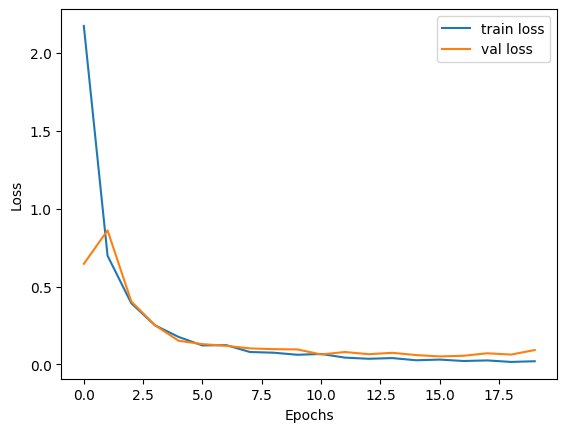

In [33]:
h = history

# plotting loss value
plt.plot(h.history['loss'],label='train loss')
plt.plot(h.history['val_loss'],label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

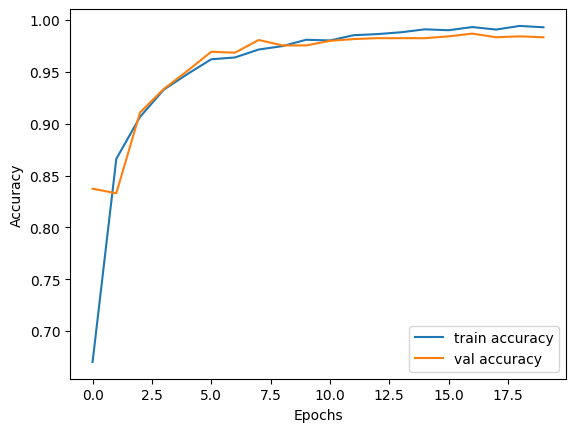

In [34]:
# plotting accuracy value
plt.plot(h.history['accuracy'],label='train accuracy')
plt.plot(h.history['val_accuracy'],label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9917 - loss: 0.0623
Test Accuracy: 0.9855072498321533


In [36]:
y_test = test_generator.classes
y_test_hat = np.argmax(model.predict(test_generator), axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step


In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report

In [38]:
cm = confusion_matrix(y_test, y_test_hat)
cm

array([[288,  11,   0,   1],
       [  1, 303,   1,   1],
       [  0,   1, 404,   0],
       [  0,   3,   0, 297]])

In [39]:
test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

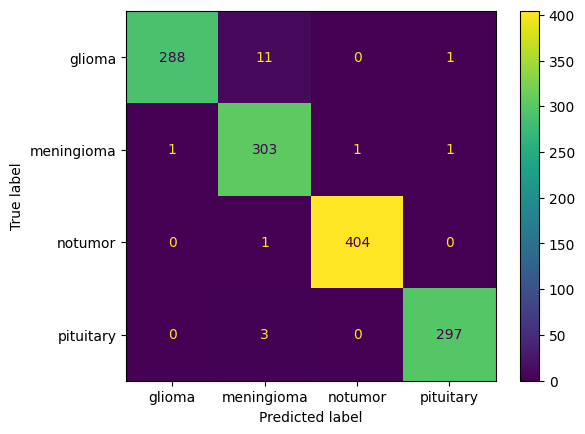

In [40]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])
cm_display.plot()
plt.show()

In [41]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       300
           1       0.95      0.99      0.97       306
           2       1.00      1.00      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



In [42]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/

    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array

    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 240, 240, 3))
  warnings.warn(msg)


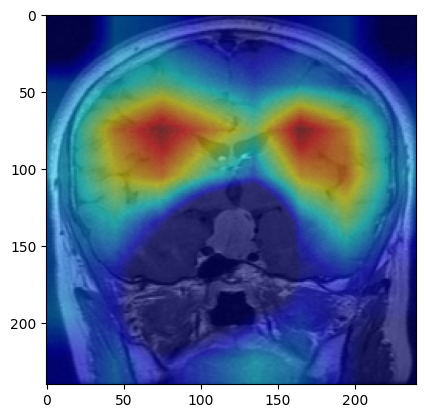

In [43]:
test_img = cv2.imread("/content/Cropped_Training/pituitary/cropped_Tr-piTr_0002.jpg")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [44]:
model.save('braintumour_detection.h5')

In [54]:
# Building a predictive system
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    cropped_img = crop_image(image)  # Using your crop_image function
    resized_img = cv2.resize(cropped_img, (240, 240))
    # If your model expects normalized data, add normalization here (e.g., resized_img / 255.0)
    return resized_img

def make_prediction(img_path):
  processed_image = preprocess_image(img_path)
  img = np.expand_dims(processed_image,axis=0)
  prediction = model.predict(img)
  predicted_class_index = np.argmax(prediction)
  class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Replace with your actual labels
  predicted_class_name = class_labels[predicted_class_index]

  return predicted_class_name

In [56]:
print(make_prediction("/content/Testing/glioma/Te-glTr_0008.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
glioma
